#### Last Modified: July 26th, 2022 (Opal).

## sOpInf Applied to HUX Solar Wind Radial Speed Dataset for CR2210


In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM-Revised


In [2]:
import numpy as np
import scipy.linalg as la
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy import stats
from notebook_functions import *
from hux_code.numerical_methods import apply_numerical_method
from hux_code.hux_propagation import apply_hux_f_model
import time
import astropy.units as u

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

### Import MHD solar wind velocity results.

In [4]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
# read in MHD velocity results. 
vr_model = model['vr']

In [5]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km) 
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [6]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

In [7]:
#force periodicity on f
#since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

In [8]:
# solve for the velocity field using HUX code. 
V = apply_hux_f_model(f[:, 55, 0], (r[1:]-r[:-1]).to(u.km).value, p[1:] -p[:-1]).T

In [9]:
V.shape

(129, 140)

### Background:  Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

In [10]:
def plot_heat_data(Z, title, sample_columns=np.append(np.arange(0, len(r), 20),len(r) -1), variable="v", xlabel="$\phi$ (Deg.)", 
                  save_fig=False, file_name=None):
    fig, ax = plt.subplots(figsize=(14, 4))
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(p*(180/np.pi), Z[:,j], color=next(color), label=str(variable) + rf"$(\phi,r$" + "=" + 
                str(round(r[j].to(u.AU).value,2)) + " AU)")

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel(variable + " (km/s)", fontsize=15)
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.suptitle(title, fontsize=15)
    
    if save_fig:
        fig.savefig(file_name, dpi=500, bbox_inches='tight')

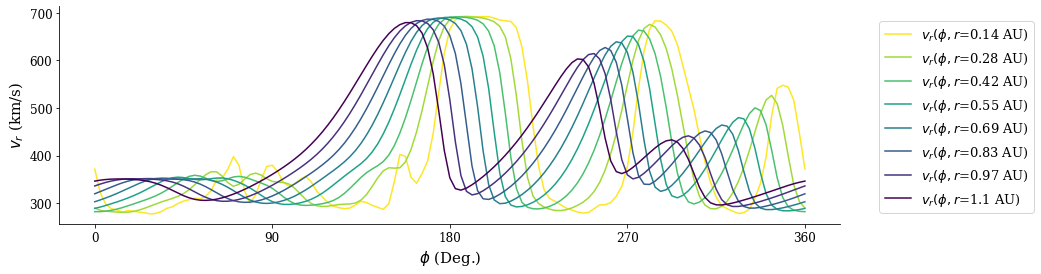

In [11]:
plot_heat_data(V, "", variable=r"$v_{r}$", save_fig=True, file_name="HUX/figs/CR"+ str(cr) +"/original_dataset_HUX.png")

In [12]:
def periodic_corr_np(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return np.correlate(x, np.hstack((y[1:], y)), mode='valid')

def normalize(x):
    return (x - np.mean(x))/np.std(x)

In [13]:
shift_vec = [0]
for ii in range(1, len(r)):
    corr = periodic_corr_np(V[:, 0], V[:, ii])
    shift_vec.append(-p[np.argmax(corr)]*180/np.pi)

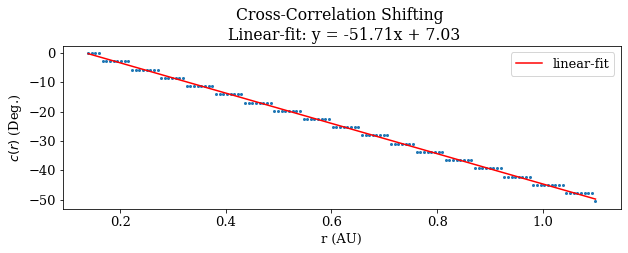

In [14]:
fig, ax = plt.subplots(figsize =(10, 3))
ax.scatter(r.to(u.AU), shift_vec, s=4)

n = int(len(r)*0.7)
m, b = np.polyfit(r[:n].to(u.AU).value, shift_vec[:n], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, c="r", label="linear-fit")
_ = ax.legend()
_ = ax.set_xlabel("r (AU)")
_ = ax.set_ylabel("$c(r)$ (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting \n Linear-fit: y = " + str(round(m, 2)) + "x + " + str(round(b, 2)))

In [15]:
def shift_function(r, r_idx, m, b, method="cce"):
    if method=="cce":
        return m * r + b
    if method=="moc":
        return np.loadtxt('HUX/shock_curve_S1.csv', delimiter=',')[r_idx]

In [21]:
V_new = np.zeros((len(p), len(r)))

V_new[:, 0] = V[:, 0]

for jj in range(1, len(r)):
    # compute shift from the linear fit above. 
    shift = shift_function(r[jj].to(u.AU).value, r_idx=jj, m=m, b=b, method="cce")
    # interpolate over the shifted coordinate
    V_new[:, jj] = np.interp(p + shift*(np.pi/180), p, V[:, jj], period=2*np.pi)

(3.7, 4.2)

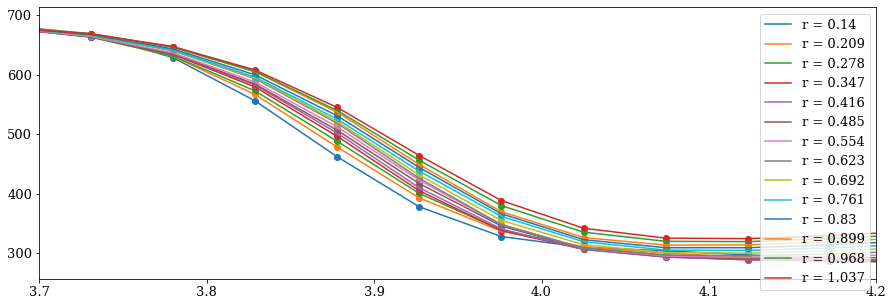

In [23]:
fig, ax= plt.subplots(figsize=(15, 5))
for ii in np.arange(0, len(r), 10):
    if r[ii].to(u.AU).value < 1.1:
        ax.plot(p, V_new[:, ii], linestyle="-", label="r = " + str(round(r[ii].to(u.AU).value, 3)))
        ax.scatter(p, V_new[:, ii], linestyle="-")
ax.legend()
ax.set_xlim(3.7, 4.2)

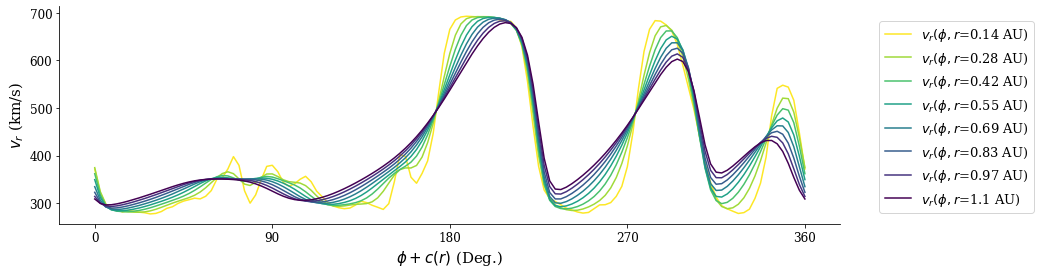

In [17]:
plot_heat_data(V_new, "", variable=r"$v_{r}$", xlabel=r"$\phi + c(r)$ (Deg.)", 
              save_fig=True, file_name="HUX/figs/CR"+ str(cr) +"/shifted_dataset_HUX.png")

## Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [19]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))

In [20]:
X=V_new

In [21]:
X_train = V_new[:, :l]
X_test = V_new[:, l:]

In [22]:
r_train = r[:l]
r_test = r[l:]

In [23]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (129, 98)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (129, 42)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


## Using the ROM Operator Inference Package

### Choosing the Reduced-model Dimension
A simple choice for $r$ is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.

In [24]:
svdvals = la.svdvals(X_train)
svdvals_prev = la.svdvals(V[:, :l])

In [25]:
# Calculate the cumulative energy.
thresh = .998
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 4
r (Eularian coordinates)= 7


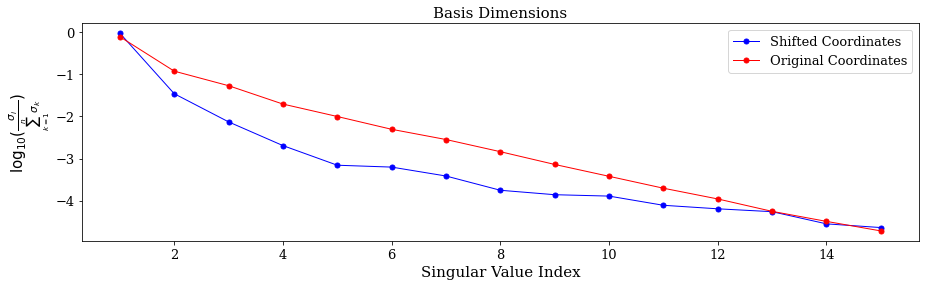

In [26]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
#plot singluar values cumulative energy
ax.plot(np.arange(1, 16), np.log10(svdvals[:15]/ np.sum(svdvals)), '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, 16), np.log10(svdvals_prev[:15]/ np.sum(svdvals_prev)), '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")


plt.legend()
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"$\log_{10}(\frac{\sigma_{i}}{\sum_{k=1}^{n} \sigma_{k}})$", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)

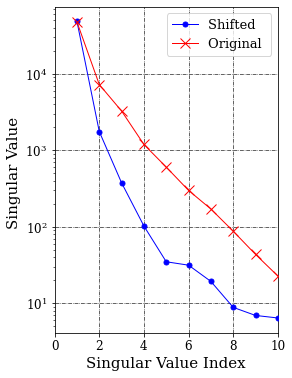

In [27]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(4, 6))

xlim= 10
ax.plot(np.arange(1, xlim + 1), svdvals[:xlim], '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted ")
ax.plot(np.arange(1, xlim + 1), svdvals_prev[:xlim], 'x-', ms=10, lw=1, zorder=3, c="r", label="Original ")

_ = ax.legend()
_ = ax.set_xlim(0, xlim)
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Singular Value ", fontsize=15)
_ = ax.set_yscale("log")
_ = ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks([0, 2, 4, 6, 8,10])
ax.axvline(2, color="black", linewidth=.6, linestyle="-.")
ax.axvline(4,  color="black", linewidth=.6, linestyle="-.")
ax.axvline(6, color="black", linewidth=.6, linestyle="-.")
ax.axvline(8, color="black", linewidth=.6, linestyle="-.")
ax.axhline(1e1, color="black", linewidth=.6, linestyle="-.")
ax.axhline(1e2, color="black", linewidth=.6, linestyle="-.")
ax.axhline(1e3, color="black", linewidth=.6, linestyle="-.")
ax.axhline(1e4, color="black", linewidth=.6, linestyle="-.")
#ax.axhline(1e-1,  color="black", linewidth=.6, linestyle="-.")
#ax.axhline(1e-2, color="black", linewidth=.6, linestyle="-.")
#ax.axhline(1e0, color="black", linewidth=.6, linestyle="-.")

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [28]:
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (129, 4)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

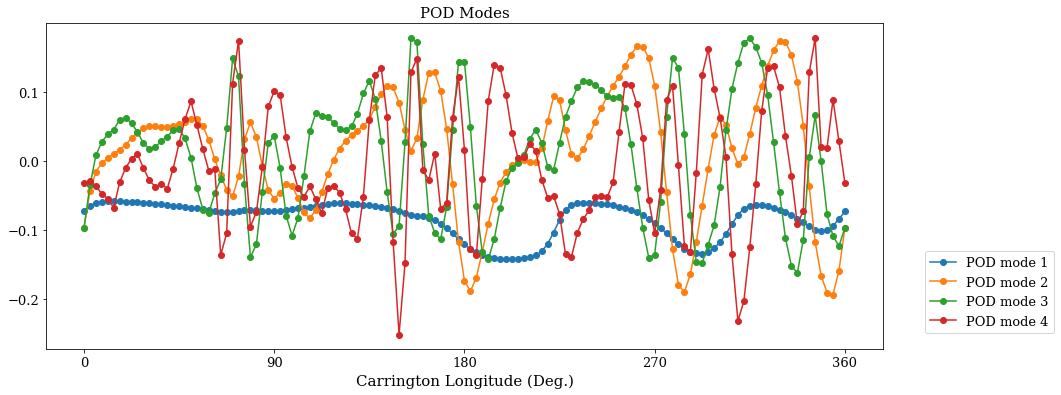

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))

for ii in range(0, Vr.shape[1]):
    ax.plot((180/np.pi) * p, Vr[:len(p),ii], "-o", label=f"POD mode {ii+1}")

ax.legend(loc=(1.05, .05))
    
ax.set_xlabel("Carrington Longitude (Deg.)", fontsize=15)
ax.set_title("POD Modes", fontsize=15)
ax.set_xticks([0, 90, 180, 270, 360])
plt.show()

In [30]:
roi.pre.projection_error(X_train, Vr)

0.0011016185612829318

# Quadratic ROM 
$$\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{H} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$$

In [31]:
rank = 4 # initialize the rank of ROM
Vr, _ = roi.pre.pod_basis(X_train, r=rank)                    # Construct the reduced basis.
Xdot = roi.pre.xdot_nonuniform(X_train, r_train.value)   # Calculate the right-hand side matrix (second-order difference scheme).
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=1e5)                     # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.

In [32]:
V_ROM_H = convert_from_x_to_v(X_ROM=X_ROM, r=r, p=p, m=m, b=b, shift_function=shift_function, method="cce")

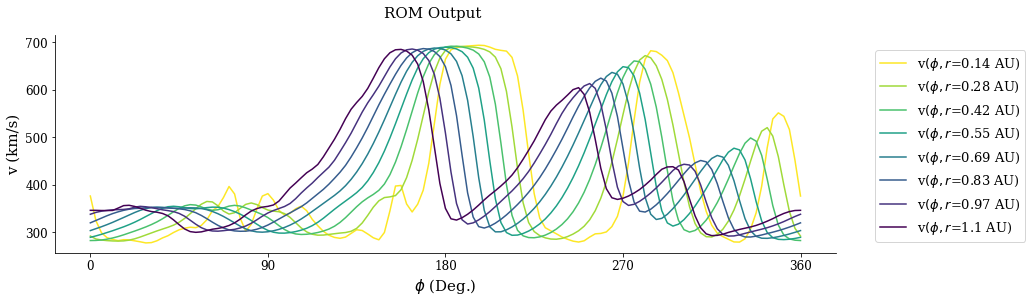

In [33]:
plot_heat_data(V_ROM_H, "ROM Output", variable="v")

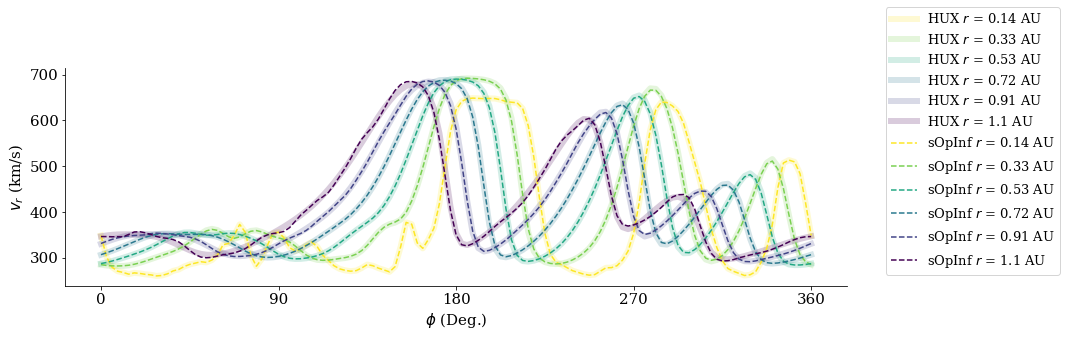

In [42]:
sample_columns = np.arange(0, len(r), int(len(r)//5))
sample_columns = np.append(sample_columns, len(r) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    if j == 0:
        ax.plot(p*(180/np.pi), f[:, 55, j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"HUX $r$ = "+
            str(round(r[j].to(u.AU).value,2)) + " AU")
    else:
        ax.plot(p*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"HUX $r$ = "+
            str(round(r[j].to(u.AU).value,2)) + " AU")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    if j == 0:
        ax.plot(p*(180/np.pi), f[:, 55, j], "--", color=curr_color, label=r"sOpInf $r$ = " + 
        str(round(r[j].to(u.AU).value,2)) + " AU")
    else:
        ax.plot(p*(180/np.pi), V_ROM_H[:,j], "--", color=curr_color, label=rf"sOpInf $r$ = " + 
            str(round(r[j].to(u.AU).value,2)) + " AU")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=15)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v_{r}$ (km/s)", fontsize=15)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=15)

fig.savefig("HUX/figs/CR" + str(cr) + "/H/sopinf_vs_hux_H.png", dpi=500, bbox_inches='tight')

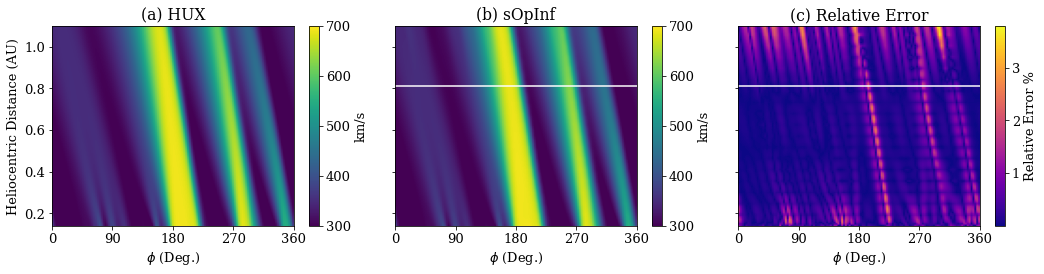

In [35]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
pos = ax[0].imshow(V.T, extent=[0,360,r[0].to(u.AU).value, 
                                r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto", origin="lower")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"Heliocentric Distance (AU)")
ax[0].set_title("(a) HUX")
ax[0].set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM_H.T, extent=[0,360,r[0].to(u.AU).value, 
                                    r[-1].to(u.AU).value], vmax=700, vmin=300, aspect="auto",  origin="lower")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("(b) sOpInf")
ax[1].set_xticks([0, 90, 180, 270, 360])
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(100*np.abs(V_ROM_H.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r[0].to(u.AU).value, r[-1].to(u.AU).value], 
                   cmap="plasma", aspect="auto", origin="lower")

ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("(c) Relative Error")
ax[2].set_xticks([0, 90, 180, 270, 360])
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error %', rotation=90)

plt.tight_layout()

fig.savefig("HUX/figs/CR" + str(cr) + "/H/shifted_HUX_relative_error_H.png", dpi=500, bbox_inches='tight')

In [36]:
print("training mean relative error = ", 100*np.mean(np.abs((V[:, :l]- V_ROM_H[:, :l]))/np.abs(V[:, :l])))
print("training median relative error = ", 100*np.median(np.abs((V[:, :l]- V_ROM_H[:, :l]))/np.abs(V[:, :l])))
print("training max relative error = ", 100*np.max(np.abs((V[:, :l]- V_ROM_H[:, :l]))/np.abs(V[:, :l])))

training mean relative error =  0.274042227269223
training median relative error =  0.13434978751039853
training max relative error =  2.5791986877144852


In [37]:
print("testing mean relative error = ", 100*np.mean(np.abs((V[:, l:]- V_ROM_H[:, l:]))/np.abs(V[:, l:])))
print("testing median relative error = ", 100*np.median(np.abs((V[:, l:]- V_ROM_H[:, l:]))/np.abs(V[:, l:])))
print("testing max relative error = ", 100*np.max(np.abs((V[:, l:]- V_ROM_H[:, l:]))/np.abs(V[:, l:])))

testing mean relative error =  0.5321699762857758
testing median relative error =  0.3848766258075827
testing max relative error =  3.789063522462647


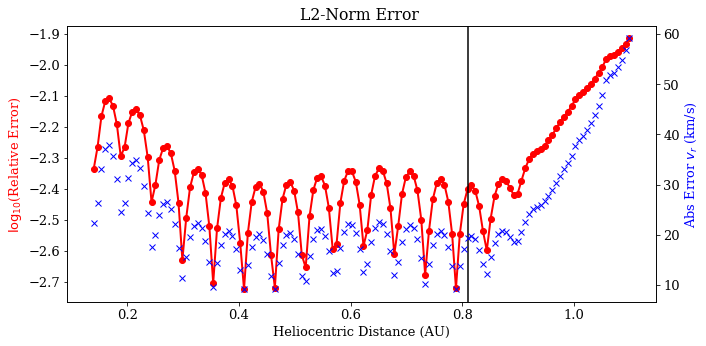

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2errH, rel_l2errH = roi.post.lp_error(V, V_ROM_H)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2errH),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"L2-Norm Error ")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2errH, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

#plt.savefig("HUX/figs/CR" + str(cr) + "/H/L2_error_operator_inference.png", dpi=300)

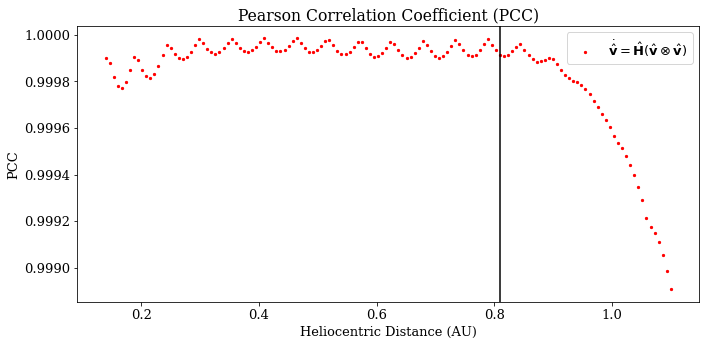

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(V[:, jj], V_ROM_H[:, jj])[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="r", s=5)
_ = ax.scatter(np.nan, np.nan, s=5, c="r", label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}}) $")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient (PCC)")
_ = ax.legend()
plt.tight_layout()
#plt.savefig("HUX/figs/CR" + str(cr) + "/H/pcc_shifted_operator_inference_comparison.png", dpi=300)

In [40]:
print("2d pcc = ", stats.pearsonr(np.ndarray.flatten(V), np.ndarray.flatten(V_ROM_H))[0])
print("2d pcc training = ", stats.pearsonr(np.ndarray.flatten(V[:, :l]), np.ndarray.flatten(V_ROM_H[:, :l]))[0])
print("2d pcc testing = ", stats.pearsonr(np.ndarray.flatten(V[:, l:]), np.ndarray.flatten(V_ROM_H[:, l:]))[0])

2d pcc =  0.9998439238711986
2d pcc training =  0.9999209023708399
2d pcc testing =  0.999632884833166


### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$ and rank $r$.

In [46]:
coeff_array = 10**np.linspace(5, 10, 20)
rank_array = [4]

training_error = np.ones((len(coeff_array), len(rank_array))) * np.inf
testing_error = np.ones((len(coeff_array), len(rank_array))) * np.inf

for kk, coeff in enumerate(coeff_array):
    for ii, rank_r in enumerate(rank_array):
        Vr, _ = roi.pre.pod_basis(X_train, r=rank_r) 
        Xdot = roi.pre.xdot_nonuniform(X_train, r_train.value) 
        model = roi.InferredContinuousROM(modelform="H")            
        model.fit(Vr, X_train, Xdot, P=coeff)                          
        X_ROM = model.predict(X[:, 0], r.value, method="BDF", 
                              max_step=(r_train[1] - r_train[0]).value) 
        
        if np.shape(X_ROM) == np.shape(V):
            V_ROM = convert_from_x_to_v(X_ROM=X_ROM, r=r, p=p, m=m, b=b, shift_function=shift_function, method="cce")
            # save
            training_error[kk, ii] = np.max(np.abs((V[:, :l] - V_ROM[:, :l])/V[:, :l]))
            # save
            testing_error[kk, ii] = np.max(np.abs((V[:, l:] - V_ROM[:, l:])/V[:, l:]))

In [47]:
idx  = np.unravel_index(training_error.argmin(), training_error.shape)
print("Training lambda =",  np.log10(coeff_array[idx[0]]))
print("Training rank =",  rank_array[idx[1]])

Training lambda = 5.0
Training rank = 4


In [48]:
idx  = np.unravel_index(testing_error.argmin(), testing_error.shape)
print("Testing lambda =",  np.log10(coeff_array[idx[0]]))
print("Testing rank =",  rank_array[idx[1]])

Testing lambda = 5.7894736842105265
Testing rank = 4


# Sensitivity to Training Data

In [49]:
# initialize the training length. 
l1, l2, l3 = int(0.5*len(r)), int(0.6*len(r)), int(0.7*len(r))

X_train1 = X[:, :l1]
X_test1 = X[:, l1:-1]


X_train2 = X[:, :l2]
X_test2 = X[:, l2:-1]


X_train3 = X[:, :l3]
X_test3 = X[:, l3:-1]

In [50]:
r_train1 = r[:l1]
r_test1 = r[l1:-1]

r_train2 = r[:l2]
r_test2 = r[l2:-1]

r_train3 = r[:l3]
r_test3 = r[l3:-1]

In [51]:
# l1 = compute the results for quadradic with 3 modes.
rank=4
Vr, _ = roi.pre.pod_basis(X_train1, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train1, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train1, Xdot, P=1e5)                          # Construct the ROM with Operator Inference.
X_ROM1 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM1 = convert_from_x_to_v(X_ROM=X_ROM1, r=r, p=p, m=m, b=b, shift_function=shift_function, method="cce")

# l2 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train2, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train2, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train2, Xdot, P=1e5)                          # Construct the ROM with Operator Inference.
X_ROM2 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM2 = convert_from_x_to_v(X_ROM=X_ROM2, r=r, p=p, m=m, b=b, shift_function=shift_function, method="cce")

# l3 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train3, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train3, (r_train[1] - r_train[0]).value, order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train3, Xdot, P=1e5)                          # Construct the ROM with Operator Inference.
X_ROM3 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM3 = convert_from_x_to_v(X_ROM=X_ROM3, r=r, p=p, m=m, b=b, shift_function=shift_function, method="cce")

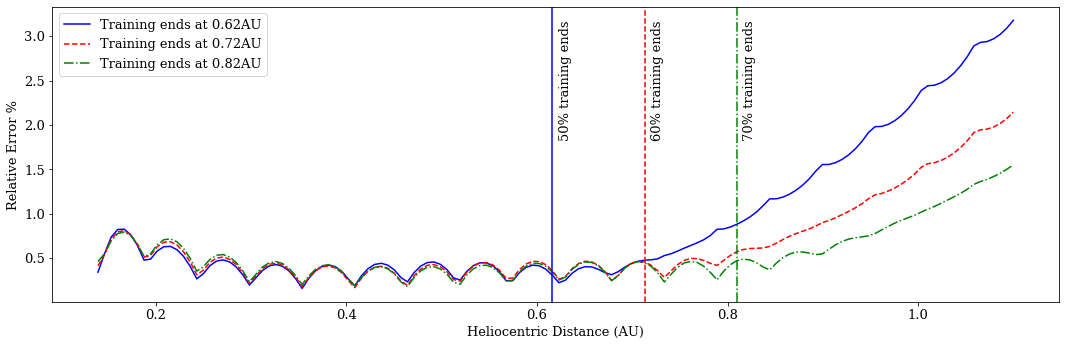

In [52]:
fig, ax = plt.subplots(figsize=(15, 5))
# l1
abs_l2err1, rel_l2err1 = roi.post.lp_error(V, V_ROM1)
_ = ax.plot(r.to(u.AU).value, 100*rel_l2err1, "-", c="b", label="Training ends at " + str(round(r[l1].to(u.AU).value, 2)) + "AU")

#l2
abs_l2err2, rel_l2err2 = roi.post.lp_error(V, V_ROM2)
_ = ax.plot(r.to(u.AU).value, 100*rel_l2err2, "--", c="r", label="Training ends at " + str(round(r[l2].to(u.AU).value, 2)) + "AU")

#l3
abs_l2err3, rel_l2err3 = roi.post.lp_error(V, V_ROM3)
_ = ax.plot(r.to(u.AU).value, 100*rel_l2err3, "-.", c="g", label="Training ends at " + str(round(r[l3].to(u.AU).value, 2)) + "AU")

_ = ax.axvline(r_train1[-1].to(u.AU).value, linestyle="-", c="b")
_ = ax.axvline(r_train2[-1].to(u.AU).value, linestyle="--", c="r")
_ = ax.axvline(r_train3[-1].to(u.AU).value, linestyle="-.", c="g")
_ = ax.set_ylabel("Relative Error %")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.text(r[l1].to(u.AU).value, 2.5,  "50% training ends", rotation=90, verticalalignment='center')
_ = ax.text(r[l2].to(u.AU).value, 2.5,  "60% training ends", rotation=90, verticalalignment='center')
_ = ax.text(r[l3].to(u.AU).value, 2.5,  "70% training ends", rotation=90, verticalalignment='center')
plt.legend()

plt.tight_layout()

plt.savefig("HUX/figs/CR" + str(cr) + "/A/sensitivity_to_number_of_training_snapshots.png", dpi=300)